# Installation

conda create -n liana -y python=3.8 ipykernel # liana requires ipykernel

conda activate liana

conda install -c anaconda pytables

pip install torch

pip3 install torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

pip install decoupler cell2cell omnipath pyarrow git+https://github.com/saezlab/liana-py # Need dev version

# Setup

LIANA can run on a normal JupyterLab GPU job.

In Python, make sure we have CUDA installed correctly

In [ ]:
# Standard stuff
import scanpy as sc
import liana as li
import cell2cell as c2c
import decoupler as dc
from collections import defaultdict
import omnipath as op
import fast_matrix_market as fmm
import pandas as pd
import anndata as ad
import numpy as np
from statsmodels.stats.multitest import fdrcorrection

# Plotting
import seaborn as sns
import plotnine as p9
import matplotlib.pyplot as plt
import gseapy

# Import DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

# Initiate GPU now as it's needed for even loading the tensor
import torch
torch.cuda.is_available()
import tensorly as tl
tl.set_backend("pytorch")

# Ignore all FutureWarnings
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Compute results
## Load and prepare data

In [23]:
dat = fmm.mmread("major.mtx")
cellIds = pd.read_csv("major.cells", header = None)
genes = pd.read_csv("major.genes", header = None)
anno = pd.read_csv("major.annotation", header = None)

visit = pd.read_csv("all_cells.visits", header = None)
visit.index = visit[1]
visit = visit.reindex(index = cellIds[0])

donor = cellIds[0].str.split("!!").apply(lambda x: x[0]).str.replace("_poolA|_poolB", "")
sample = donor.str.cat(list(visit[0]), sep = "_")

In [67]:
adata = ad.AnnData(X = dat.tocsr())
adata.obs_names = cellIds[0]
adata.var_names = genes[0]
adata.obs["anno"] = pd.Categorical(anno[1])
adata.obs["visit"] = pd.Categorical(visit[0])
adata.obs["donor"] = pd.Categorical(donor)
adata.obs["sample"] = pd.Categorical(sample)
adata

/tmp/ipykernel_581/1908473877.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


AnnData object with n_obs × n_vars = 131463 × 36389
    obs: 'visit', 'donor', 'sample', 'anno'

In [ ]:
adata.obs

In [5]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

/work/miniconda3/envs/liana/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.


## Calculate

In [6]:
li.mt.rank_aggregate.by_sample(
    adata,
    groupby="anno",
    sample_key="sample", # sample key by which we which to loop
    use_raw=False,
    verbose=True, # use 'full' to show all verbose information
    n_perms=100, # reduce permutations for speed
    return_all_lrs=True, # return all LR values
    )

Now running: Donor_88_visit3: 100%|██████████| 42/42 [14:52<00:00, 21.24s/it]


## Save AnnData

In [8]:
adata.write_h5ad("major.adata")

In [2]:
adata = ad.read_h5ad("major.adata")

In [9]:
tensor = li.multi.to_tensor_c2c(adata,
                                sample_key="sample",
                                score_key='magnitude_rank', # can be any score from liana
                                how='outer_cells' # how to join the samples
                                )

100%|██████████| 42/42 [18:14<00:00, 26.06s/it]


In [11]:
context_dict = adata.obs[["sample", "visit"]].drop_duplicates()
context_dict = dict(zip(context_dict["sample"], context_dict["visit"]))
context_dict = defaultdict(lambda: 'Unknown', context_dict)

tensor_meta = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                                  metadata_dicts=[context_dict, None, None, None],
                                                  fill_with_order_elements=True
                                                  )

In [12]:
tensor_meta

[            Element Category
 0   Donor_02_visit1   visit1
 1   Donor_02_visit2   visit2
 2   Donor_02_visit3   visit3
 3   Donor_05_visit1   visit1
 4   Donor_05_visit2   visit2
 5   Donor_05_visit3   visit3
 6   Donor_19_visit1   visit1
 7   Donor_19_visit2   visit2
 8   Donor_19_visit3   visit3
 9   Donor_20_visit1   visit1
 10  Donor_20_visit2   visit2
 11  Donor_20_visit3   visit3
 12  Donor_25_visit1   visit1
 13  Donor_25_visit2   visit2
 14  Donor_25_visit3   visit3
 15  Donor_29_visit1   visit1
 16  Donor_29_visit2   visit2
 17  Donor_29_visit3   visit3
 18  Donor_32_visit1   visit1
 19  Donor_32_visit2   visit2
 20  Donor_32_visit3   visit3
 21  Donor_38_visit1   visit1
 22  Donor_38_visit2   visit2
 23  Donor_38_visit3   visit3
 24  Donor_41_visit1   visit1
 25  Donor_41_visit2   visit2
 26  Donor_41_visit3   visit3
 27  Donor_50_visit1   visit1
 28  Donor_50_visit2   visit2
 29  Donor_50_visit3   visit3
 30  Donor_55_visit1   visit1
 31  Donor_55_visit2   visit2
 32  Donor

In [13]:
tensor = c2c.analysis.run_tensor_cell2cell_pipeline(tensor,
                                                    tensor_meta,
                                                    copy_tensor=True, # Whether to output a new tensor or modifying the original
                                                    rank=11, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis. Here, it was precomuputed.
                                                    tf_optimization='robust', # To define how robust we want the analysis to be.
                                                    random_state=0, # Random seed for reproducibility
                                                    device='cuda', # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                                    elbow_metric='error', # Metric to use in the elbow analysis.
                                                    smooth_elbow=False, # Whether smoothing the metric of the elbow analysis.
                                                    upper_rank=20, # Max number of factors to try in the elbow analysis
                                                    tf_init='random', # Initialization method of the tensor factorization
                                                    tf_svd='numpy_svd', # Type of SVD to use if the initialization is 'svd'
                                                    cmaps=None, # Color palettes to use in color each of the dimensions. Must be a list of palettes.
                                                    sample_col='Element', # Columns containing the elements in the tensor metadata
                                                    group_col='Category', # Columns containing the major groups in the tensor metadata
                                                    output_fig=False, # Whether to output the figures. If False, figures won't be saved a files if a folder was passed in output_folder.
                                                    )

/work/miniconda3/envs/liana/lib/python3.8/site-packages/tensorly/backend/pytorch_backend.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Running Elbow Analysis


100%|██████████| 20/20 [26:19<00:00, 78.96s/it] 


The rank at the elbow is: 11
Running Tensor Factorization


100%|██████████| 100/100 [06:12<00:00,  3.73s/it]

Best model has a normalized error of: 0.609


## Save results

In [14]:
c2c.io.export_variable_with_pickle(tensor, "tensor_major.pkl")

/work/02_data/06_cci/tensor_major.pkl  was correctly saved.


## Export data to R

In [29]:
adata.uns["liana_res"].to_csv("liana_res.csv")

# Plotting

## Load results

In [2]:
tensor = c2c.io.load_tensor("tensor_major.pkl")
adata = ad.read_h5ad("major.adata")

/work/miniconda3/envs/liana/lib/python3.8/site-packages/tensorly/backend/pytorch_backend.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Create dict and meta

## Figures 7b, Extended Data Figure 10a

In [14]:
context_dict = adata.obs[["sample", "visit"]].drop_duplicates()
context_dict = dict(zip(context_dict["sample"], context_dict["visit"]))
context_dict = defaultdict(lambda: 'Unknown', context_dict)

tensor_meta = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                                  metadata_dicts=[context_dict, None, None, None],
                                                  fill_with_order_elements=True
                                                  )

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

visit1 vs. visit2: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.937e-01 Stat=3.100e+01
visit2 vs. visit3: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:2.676e-01 Stat=3.400e+01
visit1 vs. visit3: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:6.257e-01 Stat=4.400e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

visit1 vs. visit2: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.575e-01 Stat=3.700e+01
visit2 vs. visit3: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:2.319e-03 Stat=7.000e+00
visit1 vs. visit3: Wilcoxon test (paired samples) wit

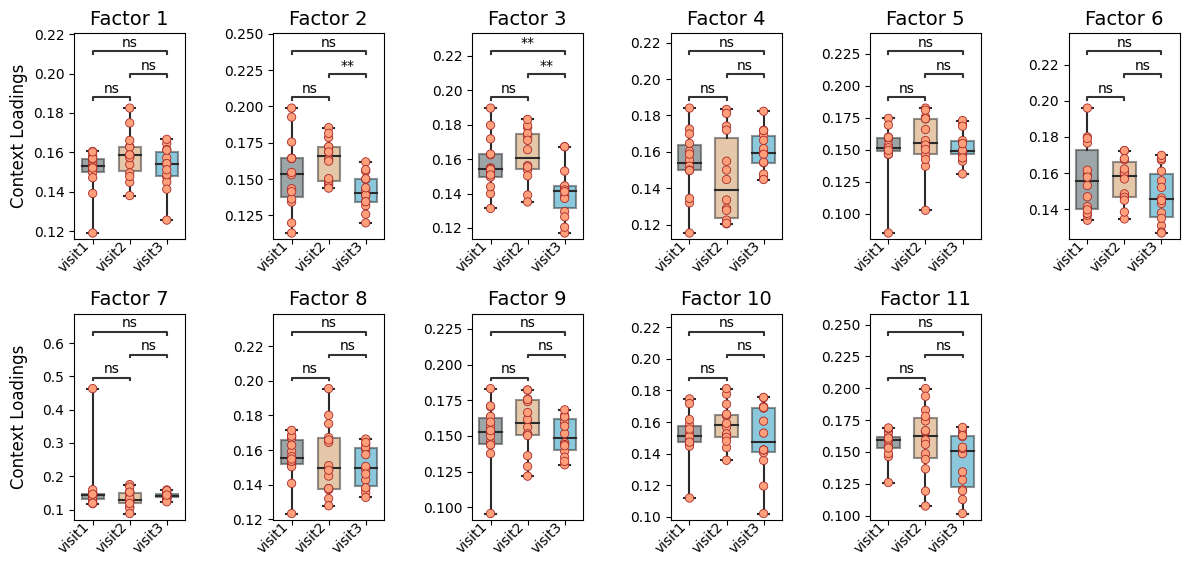

In [7]:
_ = c2c.plotting.factor_plot.context_boxplot(tensor.factors['Contexts'],
                                             metadict=context_dict,
                                             nrows=2,
                                             figsize=(12, 6),
                                             group_order=['visit1', 'visit2',"visit3"],
                                             statistical_test='Wilcoxon',
                                             pval_correction='BH',
                                             cmap=["#374E55FF","#DF8F44FF","#00A1D5FF"],
                                             verbose=True,
                                             filename=None
                                             )

plt.show()

## Figure 7c

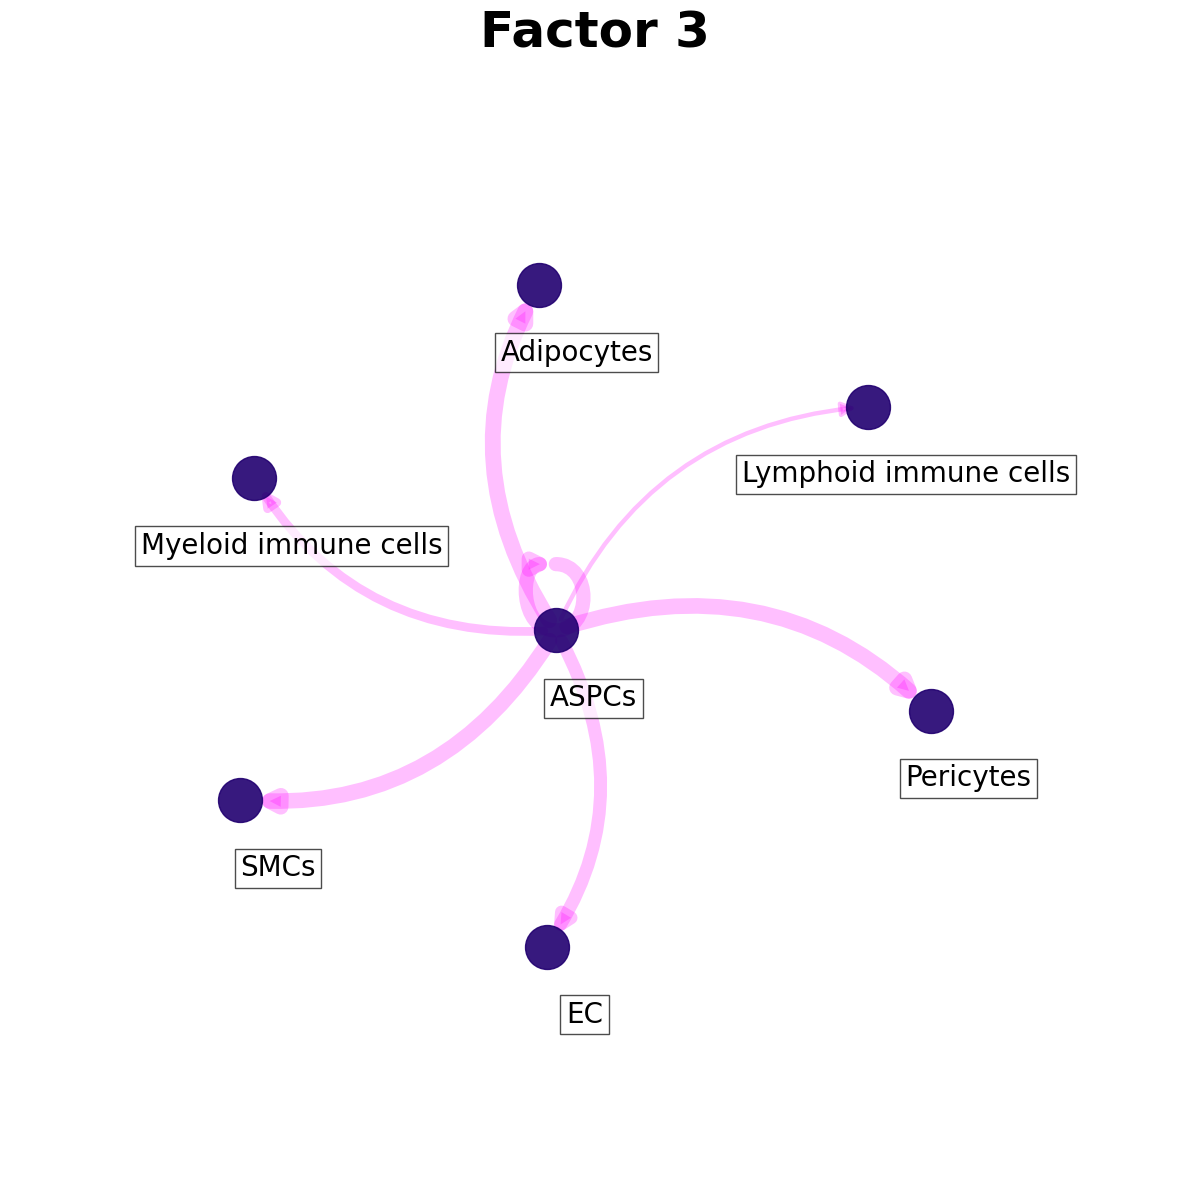

In [24]:
c2c.plotting.ccc_networks_plot(tensor,
                               included_factors=['Factor 3'],
                               ccc_threshold=0.02, # Only important communication
                               nrows=1,
                               panel_size=(12, 12), # This changes the size of each figure panel.
                              )

plt.show()

## Extended Data Figure 10b,c

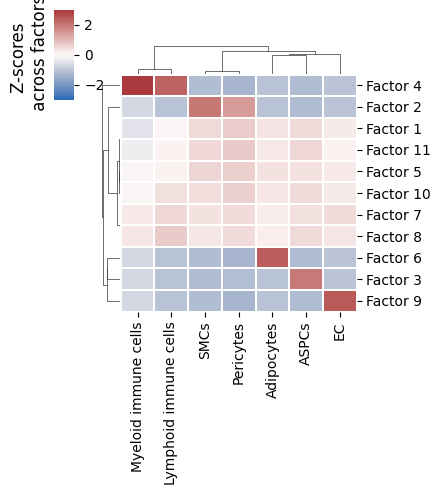

In [9]:
lr_cm = c2c.plotting.loading_clustermap(tensor.factors['Sender Cells'],
                                        loading_threshold=0.12, # To consider only top LRs
                                        use_zscore=True,
                                        figsize=(4, 5),
                                        filename=None
                                       )
plt.show()

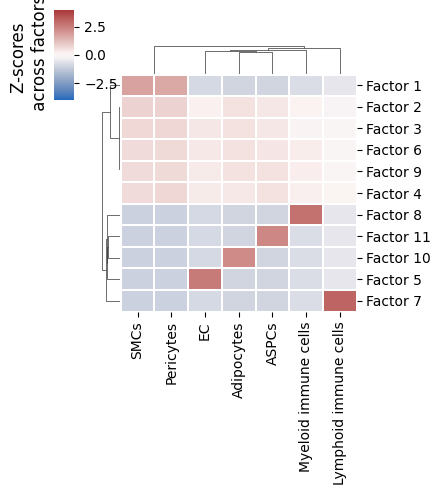

In [10]:
lr_cm = c2c.plotting.loading_clustermap(tensor.factors['Receiver Cells'],
                                        loading_threshold=0.12, # To consider only top LRs
                                        use_zscore=True,
                                        figsize=(4, 5),
                                        filename=None
                                       )
plt.show()

In [67]:
# Same as for C2C pipeline

lr_pairs = pd.read_csv('https://raw.githubusercontent.com/LewisLabUCSD/Ligand-Receptor-Pairs/master/Human/Human-2020-Jin-LR-pairs.csv')
lr_pairs = lr_pairs.astype(str)

In [68]:
pathway_per_gene = defaultdict(set)
with open('/work/02_data/00_other/c2.cp.reactome.v2023.2.Hs.symbols.gmt', 'rb') as f:
    for i, line in enumerate(f):
        l = line.decode("utf-8").split('\t')
        l[-1] = l[-1].replace('\n', '')
        l = [pw for pw in l if ('http' not in pw)] # Remove website info
        for gene in l[1:]:
            pathway_per_gene[gene] = pathway_per_gene[gene].union(set([l[0]]))

In [69]:
# If the LR db include protein complexes. 
# This is the character separating members
complex_sep = '&' 

# Dictionary to save the LR interaction (key) and the annotated pathways (values).
pathway_sets = defaultdict(set)

# Iterate through the interactions in the LR DB.
for idx, row in lr_pairs.iterrows():
    lr_label = row['interaction_symbol']
    lr = lr_label.split('^')
    
    # Gene members of the ligand and the receptor in the LR pair
    if complex_sep is None:
        ligands = [lr[0]]
        receptors = [lr[1]]
    else:
        ligands = lr[0].split(complex_sep)
        receptors = lr[1].split(complex_sep)
    
    # Find pathways associated with all members of the ligand
    for i, ligand in enumerate(ligands):
        if i == 0:
            ligand_pathways = pathway_per_gene[ligand]
        else:
            ligand_pathways = ligand_pathways.intersection(pathway_per_gene[ligand])
            
    # Find pathways associated with all members of the receptor
    for i, receptor in enumerate(receptors):
        if i == 0:
            receptor_pathways = pathway_per_gene[receptor]
        else:
            receptor_pathways = receptor_pathways.intersection(pathway_per_gene[receptor])

    # Keep only pathways that are in both ligand and receptor.
    lr_pathways = ligand_pathways.intersection(receptor_pathways)
    for p in lr_pathways:
        pathway_sets[p] = pathway_sets[p].union([lr_label])

In [70]:
K=15

lr_set = defaultdict(set)
    
for k, v in pathway_sets.items():
    if len(v) >= K:
        lr_set[k] = v

In [71]:
len(lr_set)

85

In [72]:
weight = 1
min_size = 15
permutations = 999
significance_threshold = 0.25

In [73]:
loadings = tensor.factors['Ligand-Receptor Pairs'].reset_index()

In [74]:
for factor in loadings.columns[1:]:
    # Rank LR pairs of each factor by their respective loadings
    test = loadings[['index', factor]]
    test.columns = [0, 1]
    test = test.sort_values(by=1, ascending=False)
    test.reset_index(drop=True, inplace=True)

    # RUN GSEA
    gseapy.prerank(rnk=test,
                   gene_sets=lr_set,
                   min_size=min_size,
                   weighted_score_type=weight,
                   threads=12,
                   permutation_num=permutations, # reduce number to speed up testing
                   outdir='/work/02_data/00_other/C2C_GSEA/' + factor, format='png', seed=6)

2024-04-03 15:27:13,912 [WARNING] Duplicated values found in preranked stats: 34.77% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-03 15:27:14,084 [WARNING] Duplicated values found in preranked stats: 34.35% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-03 15:27:14,249 [WARNING] Duplicated values found in preranked stats: 32.86% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-03 15:27:14,413 [WARNING] Duplicated values found in preranked stats: 43.70% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-03 15:27:16,784 [WARNING] Duplicated values found in preranked stats: 40.47% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-03 15:27:16,962 [WARNING] Duplicated values found in preranked stats: 37.04% of genes
The order of those genes w

In [75]:
pvals = []
terms = []
factors = []
nes = []
for factor in loadings.columns[1:]:
    p_report = pd.read_csv('/work/02_data/00_other/C2C_GSEA/' + factor + '/gseapy.gene_set.prerank.report.csv')
    pval = p_report['NOM p-val'].values.tolist()
    pvals.extend(pval)
    terms.extend(p_report.Term.values.tolist())
    factors.extend([factor] * len(pval))
    nes.extend(p_report['NES'].values.tolist())
pval_df = pd.DataFrame(np.asarray([factors, terms, nes, pvals]).T, columns=['Factor', 'Term', 'NES', 'P-value'])
pval_df = pval_df.loc[pval_df['P-value'] != 'nan']
pval_df['P-value'] = pd.to_numeric(pval_df['P-value'])
pval_df['P-value'] = pval_df['P-value'].replace(0., 1./(permutations+1))
pval_df['NES'] = pd.to_numeric(pval_df['NES'])

In [76]:
pval_df['Adj. P-value'] = fdrcorrection(pval_df['P-value'].values,
                                        alpha=0.05)[1]

In [77]:
pval_df

,Factor,Term,NES,P-value,Adj. P-value
0,Factor 1,REACTOME_DEGRADATION_OF_THE_EXTRACELLULAR_MATRIX,1.051557,0.182182,0.637914
1,Factor 1,REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM,1.051398,0.197197,0.637914
2,Factor 1,REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION,1.049523,0.100100,0.637914
3,Factor 1,REACTOME_CHEMOKINE_RECEPTORS_BIND_CHEMOKINES,1.047509,0.257257,0.637914
4,Factor 1,REACTOME_HEMOSTASIS,1.046338,0.233233,0.637914
...,...,...,...,...,...
369,Factor 11,REACTOME_BETA_CATENIN_INDEPENDENT_WNT_SIGNALING,0.961987,0.718719,1.000000
370,Factor 11,REACTOME_SIGNALING_BY_WNT,0.961987,0.718719,1.000000
371,Factor 11,REACTOME_EPHA_MEDIATED_GROWTH_CONE_COLLAPSE,0.960476,0.739740,1.000000
372,Factor 11,REACTOME_CLASS_B_2_SECRETIN_FAMILY_RECEPTORS,0.923295,0.942943,1.000000


In [78]:
pval_df.loc[(pval_df['Adj. P-value'] < 0.2) & (pval_df['NES'] > 0.)]

,Factor,Term,NES,P-value,Adj. P-value
102,Factor 4,REACTOME_SIGNALING_BY_TYPE_1_INSULIN_LIKE_GROW...,1.178992,0.002002,0.124791
204,Factor 7,REACTOME_GPCR_LIGAND_BINDING,1.127057,0.001000,0.124791
205,Factor 7,REACTOME_SIGNALING_BY_GPCR,1.127057,0.001000,0.124791
206,Factor 7,REACTOME_CLASS_A_1_RHODOPSIN_LIKE_RECEPTORS,1.115789,0.004004,0.166389
307,Factor 10,REACTOME_CLASS_A_1_RHODOPSIN_LIKE_RECEPTORS,1.143453,0.003003,0.140390
308,Factor 10,REACTOME_PEPTIDE_LIGAND_BINDING_RECEPTORS,1.142243,0.002002,0.124791
309,Factor 10,REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION,1.123825,0.003003,0.140390
340,Factor 11,REACTOME_CLASS_A_1_RHODOPSIN_LIKE_RECEPTORS,1.170608,0.002002,0.124791
341,Factor 11,REACTOME_PEPTIDE_LIGAND_BINDING_RECEPTORS,1.169720,0.002002,0.124791


In [79]:
pval_df.loc[(pval_df['Adj. P-value'] < 0.2) & (pval_df['NES'] < 0.)]

,Factor,Term,NES,P-value,Adj. P-value


In [80]:
pval_pivot = pval_df.pivot(index="Term", columns="Factor", values="Adj. P-value").fillna(1.)
scores = pval_df.pivot(index="Term", columns="Factor", values="NES").fillna(0)

### Plot

In [1]:
with sns.axes_style("darkgrid"):
    dotplot = c2c.plotting.pval_plot.generate_dot_plot(pval_df=pval_pivot,
                                                       score_df=scores,
                                                       significance=significance_threshold,
                                                       xlabel='',
                                                       ylabel='KEGG Pathways',
                                                       cbar_title='NES',
                                                       cmap='PuOr',
                                                       figsize=(4,6),
                                                       label_size=7,
                                                       title_size=7,
                                                       tick_size=7
                                                       #filename=output_folder + '/GSEA-Dotplot.svg'
                                                      )

plt.show()

NameError: name 'sns' is not defined

https://liana-py.readthedocs.io/en/latest/notebooks/liana_c2c.html#Factorization-Results

In [ ]:
dat = fmm.mmread("/work/02_data/06_cci/major.mtx")
cellIds = pd.read_csv("/work/02_data/06_cci/major.cells", header = None)
genes = pd.read_csv("/work/02_data/06_cci/major.genes", header = None)
anno = pd.read_csv("/work/02_data/06_cci/major.annotation", header = None)

visit = pd.read_csv("/work/02_data/05_velocity/all_cells.visits", header = None)
visit.index = visit[1]
visit = visit.reindex(index = cellIds[0])

donor = cellIds[0].str.split("!!").apply(lambda x: x[0]).str.replace("_poolA|_poolB", "")
sample = donor.str.cat(list(visit[0]), sep = "_")

In [ ]:
adata = ad.AnnData(X = dat.tocsr())
adata.obs_names = cellIds[0]
adata.var_names = genes[0]
adata.obs["anno"] = pd.Categorical(anno[1])
adata.obs["visit"] = pd.Categorical(visit[0])
adata.obs["donor"] = pd.Categorical(donor)
adata.obs["sample"] = pd.Categorical(sample)
adata = adata[~adata.obs["anno"].isin(["Mast cells"])]
adata

In [ ]:
sample_key = 'sample'
groupby = 'anno'
condition_key = 'visit'

DE

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

pdata = dc.get_pseudobulk(
    adata,
    sample_col=sample_key,
    groups_col=groupby,
    mode='sum',
    min_cells=10,
    min_counts=10000
)

pdata = pdata[pdata.obs["anno"] != "Lymphatic endothelial cells", :]
pdata

In [ ]:
pdata.obs

In [ ]:
%%capture
dea_results = {}
for cell_group in pdata.obs[groupby].unique():
    # Select cell profiles
    ctdata = pdata[pdata.obs[groupby] == cell_group].copy()

    # Obtain genes that pass the edgeR-like thresholds
    # NOTE: QC thresholds might differ between cell types, consider applying them by cell type
    genes = dc.filter_by_expr(ctdata,
                              group=condition_key,
                              min_count=5, # a minimum number of counts in a number of samples
                              min_total_count=10 # a minimum total number of reads across samples
                              )

    # Filter by these genes
    ctdata = ctdata[:, genes].copy()

    # Build DESeq2 object
    # NOTE: this data is actually paired, so one could consider fitting the patient label as a confounder
    dds = DeseqDataSet(
        adata=ctdata,
        design_factors=condition_key,
        ref_level=[condition_key, 'visit1'], # set control as reference
        refit_cooks=True,
        n_cpus=32, # Modified !!!
    )

    # Compute LFCs
    dds.deseq2()
    # Contrast between stim and ctrl
    stat_res = DeseqStats(dds, contrast=[condition_key, 'visit3', 'visit1'], n_cpus=32)
    # Compute Wald test
    stat_res.summary()
    # Shrink LFCs
    stat_res.lfc_shrink(coeff='visit_visit3_vs_visit1') # {condition_key}_cond_vs_ref

    dea_results[cell_group] = stat_res.results_df

In [ ]:
# concat results across cell types
dea_df = pd.concat(dea_results)
dea_df = dea_df.reset_index(level = 0).rename(columns={"level_0": groupby})
dea_df

## Figure 7a

### Visit 1

In [61]:
adatacp = adata[adata.obs["visit"]=='visit1'].copy()
adatacp.obs

,anno,visit,donor,sample
Donor_02!!9984!!AATTTCCTCGTTCTAT-1,Adipocytes,visit1,Donor_02,Donor_02_visit1
Donor_02!!9984!!TCGACCTCAGTATTCG-1,Adipocytes,visit1,Donor_02,Donor_02_visit1
Donor_02!!9984!!TTATTGCGTTCTCCAC-1,Adipocytes,visit1,Donor_02,Donor_02_visit1
Donor_02!!9984!!AACAACCCATTCTGTT-1,Myeloid immune cells,visit1,Donor_02,Donor_02_visit1
Donor_02!!9984!!AGATAGAGTTGCATGT-1,Adipocytes,visit1,Donor_02,Donor_02_visit1
...,...,...,...,...
Donor_88!!9979!!ATCACGACATCGTGCG-1,EC,visit1,Donor_88,Donor_88_visit1
Donor_88!!9979!!TCGGATAGTTTACGAC-1,EC,visit1,Donor_88,Donor_88_visit1
Donor_88!!9979!!GAGTTTGCACTAACCA-1,Myeloid immune cells,visit1,Donor_88,Donor_88_visit1
Donor_88!!9979!!ACTATTCTCAACTCTT-1,Myeloid immune cells,visit1,Donor_88,Donor_88_visit1


In [62]:
lr_pairs = li.resource.select_resource('consensus')
lr_pairs = lr_pairs.astype(str)

In [9]:
lr_pairs

,ligand,receptor
0,LGALS9,PTPRC
1,LGALS9,MET
2,LGALS9,CD44
3,LGALS9,LRP1
4,LGALS9,CD47
...,...,...
4619,BMP2,ACTR2
4620,BMP15,ACTR2
4621,CSF1,CSF3R
4622,IL36G,IFNAR1


In [63]:
meta = adatacp.obs.copy()
meta["barcode"] = meta.index
meta = meta.drop("sample", 1)
meta

,anno,visit,donor,barcode
Donor_02!!9984!!AATTTCCTCGTTCTAT-1,Adipocytes,visit1,Donor_02,Donor_02!!9984!!AATTTCCTCGTTCTAT-1
Donor_02!!9984!!TCGACCTCAGTATTCG-1,Adipocytes,visit1,Donor_02,Donor_02!!9984!!TCGACCTCAGTATTCG-1
Donor_02!!9984!!TTATTGCGTTCTCCAC-1,Adipocytes,visit1,Donor_02,Donor_02!!9984!!TTATTGCGTTCTCCAC-1
Donor_02!!9984!!AACAACCCATTCTGTT-1,Myeloid immune cells,visit1,Donor_02,Donor_02!!9984!!AACAACCCATTCTGTT-1
Donor_02!!9984!!AGATAGAGTTGCATGT-1,Adipocytes,visit1,Donor_02,Donor_02!!9984!!AGATAGAGTTGCATGT-1
...,...,...,...,...
Donor_88!!9979!!ATCACGACATCGTGCG-1,EC,visit1,Donor_88,Donor_88!!9979!!ATCACGACATCGTGCG-1
Donor_88!!9979!!TCGGATAGTTTACGAC-1,EC,visit1,Donor_88,Donor_88!!9979!!TCGGATAGTTTACGAC-1
Donor_88!!9979!!GAGTTTGCACTAACCA-1,Myeloid immune cells,visit1,Donor_88,Donor_88!!9979!!GAGTTTGCACTAACCA-1
Donor_88!!9979!!ACTATTCTCAACTCTT-1,Myeloid immune cells,visit1,Donor_88,Donor_88!!9979!!ACTATTCTCAACTCTT-1


In [64]:
interactions = c2c.analysis.SingleCellInteractions(rnaseq_data=adatacp.to_df().T,
                                                   ppi_data=lr_pairs,
                                                   metadata=meta,
                                                   interaction_columns=('ligand', 'receptor'),
                                                   communication_score='expression_thresholding',
                                                   expression_threshold=0.2, # values after aggregation
                                                   cci_score='bray_curtis',
                                                   cci_type='undirected',
                                                   aggregation_method='nn_cell_fraction',
                                                   barcode_col='barcode',
                                                   celltype_col='anno',
                                                   complex_sep='&',
                                                   verbose=False)

In [65]:
interactions.compute_pairwise_communication_scores()

Computing pairwise communication
Computing communication score between EC and Adipocytes
Computing communication score between EC and ASPCs
Computing communication score between Adipocytes and Myeloid immune cells
Computing communication score between Adipocytes and Pericytes
Computing communication score between SMCs and Lymphoid immune cells
Computing communication score between SMCs and EC
Computing communication score between EC and SMCs
Computing communication score between Lymphoid immune cells and Myeloid immune cells
Computing communication score between Lymphoid immune cells and Pericytes
Computing communication score between Myeloid immune cells and Adipocytes
Computing communication score between ASPCs and Myeloid immune cells
Computing communication score between ASPCs and Pericytes
Computing communication score between Myeloid immune cells and ASPCs
Computing communication score between EC and Lymphoid immune cells
Computing communication score between EC and EC
Computing 

In [66]:
interactions.compute_pairwise_cci_scores()

Computing pairwise interactions
Computing interaction score between Adipocytes and Myeloid immune cells
Computing interaction score between Adipocytes and Pericytes
Computing interaction score between EC and SMCs
Computing interaction score between Lymphoid immune cells and Myeloid immune cells
Computing interaction score between Lymphoid immune cells and Pericytes
Computing interaction score between ASPCs and Myeloid immune cells
Computing interaction score between ASPCs and Pericytes
Computing interaction score between EC and Lymphoid immune cells
Computing interaction score between EC and EC
Computing interaction score between Myeloid immune cells and SMCs
Computing interaction score between Adipocytes and Adipocytes
Computing interaction score between Pericytes and SMCs
Computing interaction score between EC and Myeloid immune cells
Computing interaction score between ASPCs and Adipocytes
Computing interaction score between EC and Pericytes
Computing interaction score between SMCs 

In [67]:
cci_pvals = interactions.permute_cell_labels(evaluation='interactions', 
                                             permutations=10, 
                                             fdr_correction=False,
                                             verbose=True)

100%|██████████| 10/10 [00:37<00:00,  3.71s/it]


In [68]:
cci_pvals

,ASPCs,Adipocytes,EC,Lymphoid immune cells,Myeloid immune cells,Pericytes,SMCs
ASPCs,-4.440892e-16,-4.440892e-16,0.181818,0.181818,0.181818,0.363636,0.727273
Adipocytes,-4.440892e-16,9.090909e-01,0.363636,0.181818,0.181818,0.181818,0.181818
EC,1.818182e-01,3.636364e-01,0.181818,0.181818,0.181818,0.181818,0.181818
Lymphoid immune cells,1.818182e-01,1.818182e-01,0.181818,0.181818,0.181818,0.181818,0.181818
Myeloid immune cells,1.818182e-01,1.818182e-01,0.181818,0.181818,0.181818,0.181818,0.181818
Pericytes,3.636364e-01,1.818182e-01,0.181818,0.181818,0.181818,0.181818,0.181818
SMCs,7.272727e-01,1.818182e-01,0.181818,0.181818,0.181818,0.181818,0.181818


Interaction space detected as a Interactions class


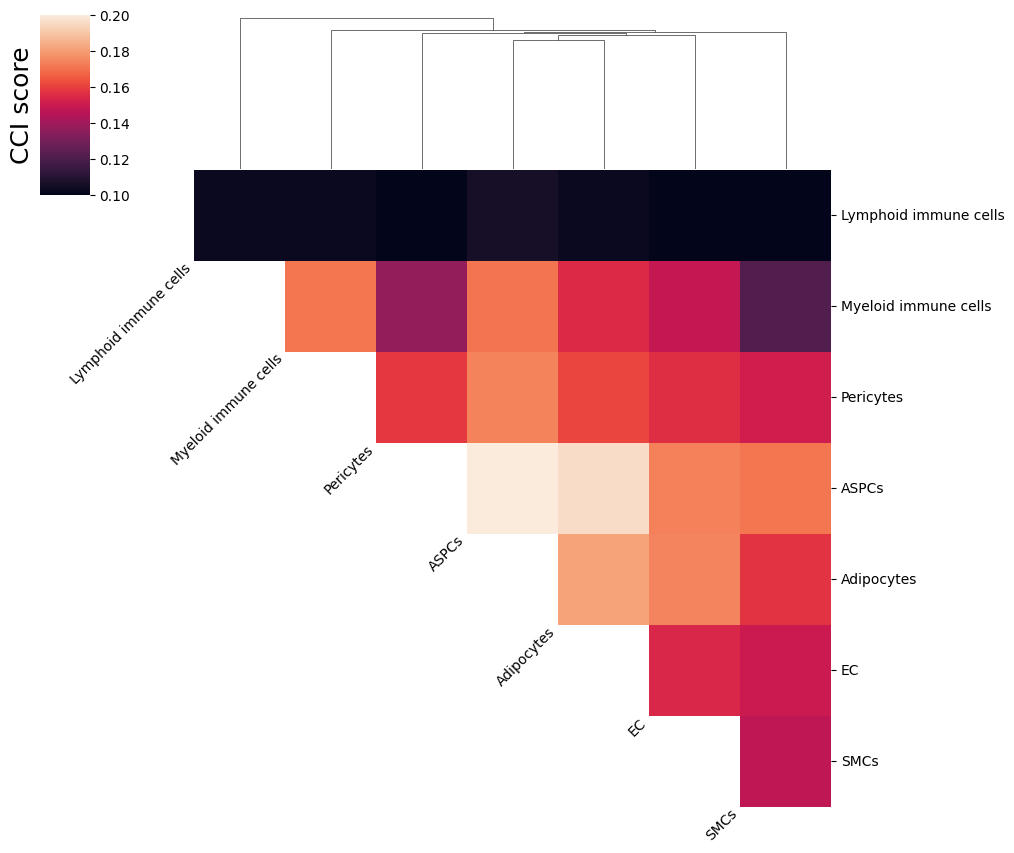

In [69]:
c2c.plotting.clustermap_cci(interactions, vmin = 0.1, vmax = 0.2)
plt.savefig(fname = "6A-visit1_CCI.pdf")
#plt.show()

In [70]:
interactions.interaction_elements["cci_matrix"].to_csv("/work/02_data/00_prints/6A-visit1_CCI.tsv", sep = "\t")

### Visit 3

In [71]:
adatacp = adata[adata.obs["visit"]=='visit3'].copy()
adatacp.obs

,anno,visit,donor,sample
Donor_02!!C748!!GCCAGTGAGCCTCTCT-1,EC,visit3,Donor_02,Donor_02_visit3
Donor_02!!C748!!AATAGAGTCCTCTTTC-1,EC,visit3,Donor_02,Donor_02_visit3
Donor_02!!C748!!AAGACAAAGACTTAAG-1,Adipocytes,visit3,Donor_02,Donor_02_visit3
Donor_02!!C748!!CGAATTGAGACCATGG-1,Adipocytes,visit3,Donor_02,Donor_02_visit3
Donor_02!!C748!!AATCACGCACCGAATT-1,Adipocytes,visit3,Donor_02,Donor_02_visit3
...,...,...,...,...
Donor_88!!C751!!CAGATTGTCCGTGCGA-1,EC,visit3,Donor_88,Donor_88_visit3
Donor_88!!C751!!CACAGGCCAATTGTGC-1,Pericytes,visit3,Donor_88,Donor_88_visit3
Donor_88!!C751!!CCTATCGGTGAGTTGG-1,ASPCs,visit3,Donor_88,Donor_88_visit3
Donor_88!!C751!!ACGCACGAGCGCTTCG-1,EC,visit3,Donor_88,Donor_88_visit3


In [8]:
lr_pairs = li.resource.select_resource('consensus')
lr_pairs = lr_pairs.astype(str)

In [9]:
lr_pairs

,ligand,receptor
0,LGALS9,PTPRC
1,LGALS9,MET
2,LGALS9,CD44
3,LGALS9,LRP1
4,LGALS9,CD47
...,...,...
4619,BMP2,ACTR2
4620,BMP15,ACTR2
4621,CSF1,CSF3R
4622,IL36G,IFNAR1


In [72]:
meta = adatacp.obs.copy()
meta["barcode"] = meta.index
meta = meta.drop("sample", 1)
meta

,anno,visit,donor,barcode
Donor_02!!C748!!GCCAGTGAGCCTCTCT-1,EC,visit3,Donor_02,Donor_02!!C748!!GCCAGTGAGCCTCTCT-1
Donor_02!!C748!!AATAGAGTCCTCTTTC-1,EC,visit3,Donor_02,Donor_02!!C748!!AATAGAGTCCTCTTTC-1
Donor_02!!C748!!AAGACAAAGACTTAAG-1,Adipocytes,visit3,Donor_02,Donor_02!!C748!!AAGACAAAGACTTAAG-1
Donor_02!!C748!!CGAATTGAGACCATGG-1,Adipocytes,visit3,Donor_02,Donor_02!!C748!!CGAATTGAGACCATGG-1
Donor_02!!C748!!AATCACGCACCGAATT-1,Adipocytes,visit3,Donor_02,Donor_02!!C748!!AATCACGCACCGAATT-1
...,...,...,...,...
Donor_88!!C751!!CAGATTGTCCGTGCGA-1,EC,visit3,Donor_88,Donor_88!!C751!!CAGATTGTCCGTGCGA-1
Donor_88!!C751!!CACAGGCCAATTGTGC-1,Pericytes,visit3,Donor_88,Donor_88!!C751!!CACAGGCCAATTGTGC-1
Donor_88!!C751!!CCTATCGGTGAGTTGG-1,ASPCs,visit3,Donor_88,Donor_88!!C751!!CCTATCGGTGAGTTGG-1
Donor_88!!C751!!ACGCACGAGCGCTTCG-1,EC,visit3,Donor_88,Donor_88!!C751!!ACGCACGAGCGCTTCG-1


In [73]:
interactions = c2c.analysis.SingleCellInteractions(rnaseq_data=adatacp.to_df().T,
                                                   ppi_data=lr_pairs,
                                                   metadata=meta,
                                                   interaction_columns=('ligand', 'receptor'),
                                                   communication_score='expression_thresholding',
                                                   expression_threshold=0.2, # values after aggregation
                                                   cci_score='bray_curtis',
                                                   cci_type='undirected',
                                                   aggregation_method='nn_cell_fraction',
                                                   barcode_col='barcode',
                                                   celltype_col='anno',
                                                   complex_sep='&',
                                                   verbose=False)

In [74]:
interactions.compute_pairwise_communication_scores()

Computing pairwise communication
Computing communication score between EC and Adipocytes
Computing communication score between EC and ASPCs
Computing communication score between Adipocytes and Myeloid immune cells
Computing communication score between Adipocytes and Pericytes
Computing communication score between SMCs and Lymphoid immune cells
Computing communication score between SMCs and EC
Computing communication score between EC and SMCs
Computing communication score between Lymphoid immune cells and Myeloid immune cells
Computing communication score between Lymphoid immune cells and Pericytes
Computing communication score between Myeloid immune cells and Adipocytes
Computing communication score between ASPCs and Myeloid immune cells
Computing communication score between ASPCs and Pericytes
Computing communication score between Myeloid immune cells and ASPCs
Computing communication score between EC and Lymphoid immune cells
Computing communication score between EC and EC
Computing 

In [75]:
interactions.compute_pairwise_cci_scores()

Computing pairwise interactions
Computing interaction score between Adipocytes and Myeloid immune cells
Computing interaction score between Adipocytes and Pericytes
Computing interaction score between EC and SMCs
Computing interaction score between Lymphoid immune cells and Myeloid immune cells
Computing interaction score between Lymphoid immune cells and Pericytes
Computing interaction score between ASPCs and Myeloid immune cells
Computing interaction score between ASPCs and Pericytes
Computing interaction score between EC and Lymphoid immune cells
Computing interaction score between EC and EC
Computing interaction score between Myeloid immune cells and SMCs
Computing interaction score between Adipocytes and Adipocytes
Computing interaction score between Pericytes and SMCs
Computing interaction score between EC and Myeloid immune cells
Computing interaction score between ASPCs and Adipocytes
Computing interaction score between EC and Pericytes
Computing interaction score between SMCs 

In [76]:
cci_pvals = interactions.permute_cell_labels(evaluation='interactions', 
                                             permutations=10, 
                                             fdr_correction=False,
                                             verbose=True)

100%|██████████| 10/10 [01:13<00:00,  7.36s/it]


In [77]:
cci_pvals

,ASPCs,Adipocytes,EC,Lymphoid immune cells,Myeloid immune cells,Pericytes,SMCs
ASPCs,-4.440892e-16,-4.440892e-16,0.181818,0.181818,0.181818,0.181818,-4.440892e-16
Adipocytes,-4.440892e-16,-4.440892e-16,0.181818,0.181818,0.181818,0.181818,1.818182e-01
EC,1.818182e-01,1.818182e-01,0.181818,0.181818,0.181818,0.181818,1.818182e-01
Lymphoid immune cells,1.818182e-01,1.818182e-01,0.181818,0.181818,0.181818,0.181818,1.818182e-01
Myeloid immune cells,1.818182e-01,1.818182e-01,0.181818,0.181818,0.181818,0.181818,1.818182e-01
Pericytes,1.818182e-01,1.818182e-01,0.181818,0.181818,0.181818,0.181818,1.818182e-01
SMCs,-4.440892e-16,1.818182e-01,0.181818,0.181818,0.181818,0.181818,1.818182e-01


Interaction space detected as a Interactions class


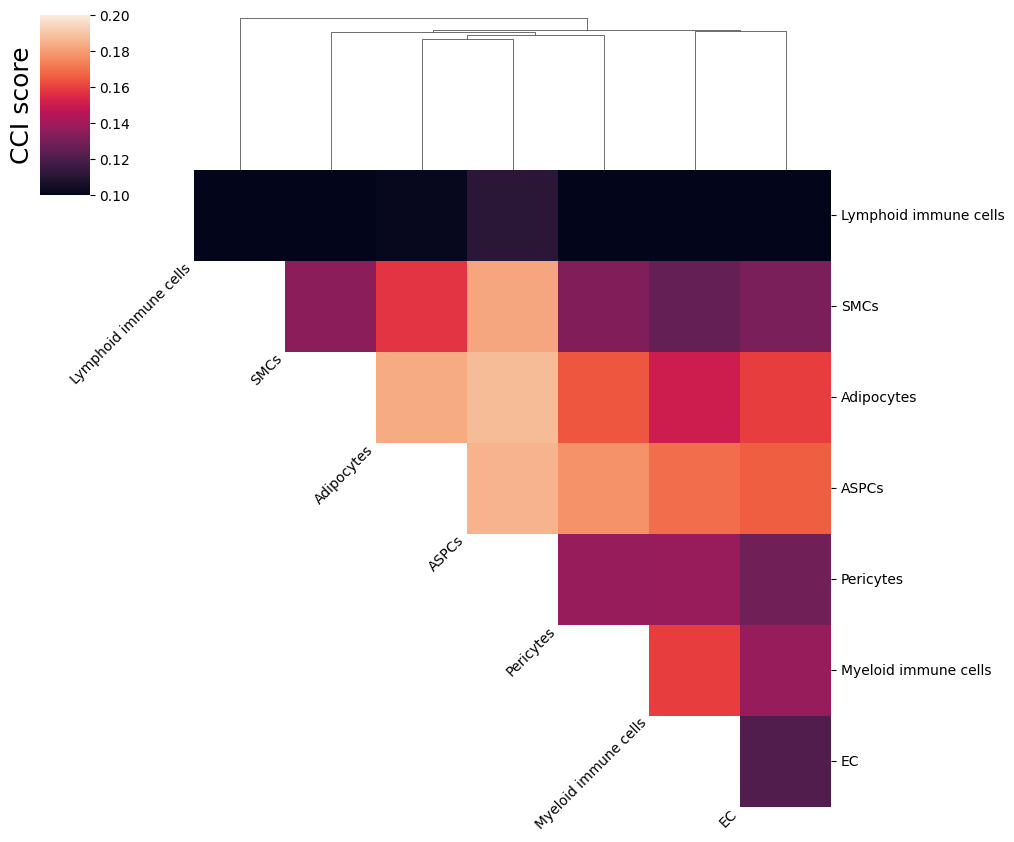

In [78]:
c2c.plotting.clustermap_cci(interactions, vmin = 0.1, vmax = 0.2)
plt.savefig(fname = "6A-visit3_CCI.pdf")

In [79]:
interactions.interaction_elements["cci_matrix"].to_csv("/work/02_data/00_prints/6A-visit3_CCI.tsv", sep = "\t")